In [4]:
import numpy as np
import numpy.linalg
import csv
from tensorflow.keras import backend
from tensorflow.keras.callbacks import ReduceLROnPlateau
import itertools
import pandas as pd
from matplotlib import pyplot as plt
import math
from scipy import spatial
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from scipy.interpolate import BivariateSpline
import tensorflow as tf
from tensorflow import keras
from scipy.stats import pearsonr
import scipy.stats as st
import matplotlib.image as mpimg
from scipy import *
from openpyxl.drawing.image import Image
from scipy.interpolate import RegularGridInterpolator
from IPython.display import Image
import scipy as scipy
import subprocess
import matplotlib
import ctypes
import clr
from fastapi import APIRouter
import os
import io
import seaborn as sns
from sklearn.linear_model import LinearRegression
import json
from pandas import json_normalize
import requests

In [5]:
def ConvertMSToBeaufort(ws):
        wsB = 0
        if ws >= 0 and ws < 0.2:
            wsB = 0
        elif ws >= 0.3 and ws < 1.5:
            wsB = 1
        elif ws >= 1.6 and ws < 3.3:
            wsB = 2
        elif ws >= 3.4 and ws < 5.4:
            wsB = 3
        elif ws >= 5.5 and ws < 7.9:
            wsB = 4

        elif ws >= 8 and ws < 10.7:
            wsB = 5
        elif ws >= 10.8 and ws < 13.8:
            wsB = 6
        elif ws >= 13.9 and ws < 17.1:
            wsB = 7
        elif ws >= 17.2 and ws < 20.7:
            wsB = 8
        elif ws >= 20.8 and ws < 24.4:
            wsB = 9
        elif ws >= 24.5 and ws < 28.4:
            wsB = 10
        elif ws >= 28.5 and ws < 32.6:
            wsB = 11
        elif ws >= 32.7:
            wsB = 12
        return wsB

In [9]:
sFile = './mappedDataNew.csv'
data = pd.read_csv(sFile,sep=',').values

wd = np.array([k for k in data])[:, 10]
for i in range(0, len(wd)):
    if float(wd[i]) > 180:
        wd[i] = float(wd[i]) - 180  # and  float(k[8])<20
data[:, 10] = wd

data[:, 12] = np.round(data[:,12].astype(float),2)
data[:, 8] = np.round(data[:,8].astype(float),2)
##knots to m/s
wfS = data[:, 11].astype(float) / (1.944)
data[:, 11] = np.round(wfS,2)

#m/s to bf
for i in range(0, len(wfS)):
    wfS[i] = ConvertMSToBeaufort(float(float(wfS[i])))
data[:, 11] = wfS

#lt/min => MT/day
data[:, 15] = ((data[:, 15]) / 1000)* 1440
##Build training data array

trData = np.array(np.append(data[:,8].reshape(-1,1),np.asmatrix([data[:,10],data[:,11],data[:,12],data[:,22],(data[:,15]),data[:,26],data[:,27],data[:,0]]).T,axis=1))#.astype(float)#data[:,26],data[:,27]
trData = np.array([k for k in trData if   float(k[2])>=0 and float(k[4])>=0 and float(k[3])>2 and float(k[5])>0  ])

trData[:,8] = list(map(lambda s: s[:-3], trData[:,8]))
d = {'draft': trData[:,0], 'wd': trData[:,1],'ws':trData[:,2],'stw':trData[:,3],'swh':trData[:,4],
     'foc':(trData[:,5]),'lat':trData[:,6],'lon':trData[:,7],'timestamp':trData[:,8] }
df  = pd.DataFrame(d)
print(trData.shape)
df.head(15)

(188848, 9)


,draft,wd,ws,stw,swh,foc,lat,lon,timestamp
0,7.7,170.26,8,2.25,1.19,14.4,54.0431,7.52594,2019-09-11 15:38
1,7.78,11.79,7,2.94,1.19,44.64,54.0424,7.52613,2019-09-11 15:40
2,7.87,16.39,8,2.94,1.19,50.4,54.0424,7.52613,2019-09-11 15:41
3,7.8,11.94,9,4.79,1.19,46.08,54.041,7.52599,2019-09-11 15:42
4,7.73,14.14,8,6.31,1.19,43.2,54.0391,7.52548,2019-09-11 15:43
5,7.64,8.96,8,7.14,1.19,40.32,54.0368,7.52468,2019-09-11 15:44
6,7.48,6.85,8,8.14,1.19,38.88,54.0343,7.52379,2019-09-11 15:45
7,7.49,174.55,9,8.14,1.19,70.56,54.0343,7.52379,2019-09-11 15:46
8,7.52,161.51,10,9.51,1.19,72,54.0312,7.52232,2019-09-11 15:47
9,7.81,139.12,9,10.11,1.19,70.56,54.0282,7.51965,2019-09-11 15:48


In [10]:
dfNew = df.iloc[:, : 6]
trData = dfNew.values
dfNew.head(15)

,draft,wd,ws,stw,swh,foc
0,7.7,170.26,8,2.25,1.19,14.4
1,7.78,11.79,7,2.94,1.19,44.64
2,7.87,16.39,8,2.94,1.19,50.4
3,7.8,11.94,9,4.79,1.19,46.08
4,7.73,14.14,8,6.31,1.19,43.2
5,7.64,8.96,8,7.14,1.19,40.32
6,7.48,6.85,8,8.14,1.19,38.88
7,7.49,174.55,9,8.14,1.19,70.56
8,7.52,161.51,10,9.51,1.19,72
9,7.81,139.12,9,10.11,1.19,70.56


In [15]:
ballastDt = np.array([k
          for k in trData if k[0] > 7 and k[0] <= 11 ]).astype(float)


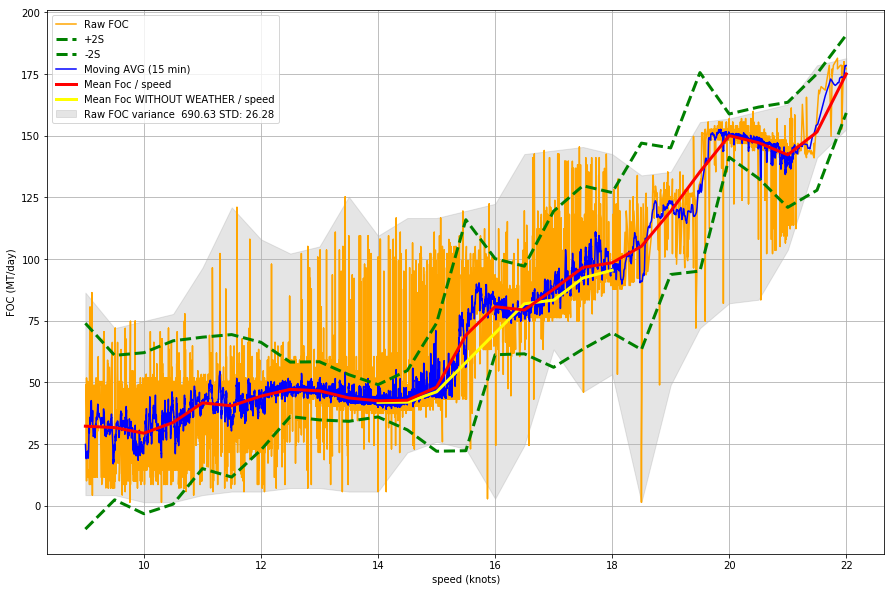

In [25]:
trDataPLot = ballastDt[ballastDt[:, 3].argsort()].astype(float)

#############
fig, ax1 = plt.subplots(figsize=(15,10))
minSpeed = 9
maxSpeed = 22
raw =  np.array([k for k in trDataPLot if   float(k[2])>=0  and float(k[4])>=0 and float(k[3])>minSpeed and
                 float(k[3])<=maxSpeed and float(k[5])>0  ])

i=minSpeed
maxSpeed = maxSpeed
sizesSpeed=[]
speed=[]
avgActualFoc=[]
minActualFoc=[]
maxActualFoc=[]
stdActualFoc=[]
while i <= maxSpeed:
        # workbook._sheets[sheet].insert_rows(k+27)

        speedArray = np.array([k for k in raw if float(k[3]) >= i-0.25 and float(k[3]) <= i + 0.25])

        if speedArray.__len__() > 1:
            sizesSpeed.append(speedArray.__len__())
            speed.append(i)
            avgActualFoc.append(np.mean(speedArray[:, 5]))
            minActualFoc.append(np.min(speedArray[:, 5]))
            maxActualFoc.append(np.max(speedArray[:, 5]))
            stdActualFoc.append(np.std(speedArray[:, 5]))
        i += 0.5

        
raw =  np.array([k for k in trDataPLot if   float(k[2])>=0  and float(k[4])>=0 and float(k[3])>minSpeed and
                 float(k[3])<=maxSpeed and float(k[5])>0  ])

minDeviation = abs(np.array(avgActualFoc) - np.array(minActualFoc))
maxDeviation =  abs(np.array(avgActualFoc) - np.array(maxActualFoc))

plt.fill_between(speed, np.array(avgActualFoc) - minDeviation , np.array(avgActualFoc) + 
                 maxDeviation,color='gray', alpha=0.2,label='Raw FOC variance  '+str(np.round(np.var(raw[:,5]),2))+" STD: "+ str(np.round(np.std(raw[:,5]),2)))

plt.plot(raw[:,3],raw[:,5],label='Raw FOC',c='orange',)

plt.plot(speed, np.array(avgActualFoc) + 2*np.array(stdActualFoc), '--' ,label='+2S',lw=3,zorder=20,color='green')
plt.plot(speed, np.array(avgActualFoc) - 2*np.array(stdActualFoc), '--',label='-2S',lw=3,zorder=20,color='green')

for i in range(0, len(trDataPLot)):
        trDataPLot[i] = np.mean(trDataPLot[i:i + 15], axis=0)


movingAvg = np.array([k for k in trDataPLot if   float(k[2])>=0 and float(k[4])>=0 and float(k[3])>minSpeed and
                 float(k[3])<=maxSpeed and float(k[5])>0   ])

plt.plot(movingAvg[:, 3], movingAvg[:, 5],label='Moving AVG (15 min)',color='blue',)


#plt.scatter(speed,avgActualFoc,s=np.array(sizesSpeed)/10,c='red',zorder=20)

####WITHOUT WEATHER CONDS
raw =  np.array([k for k in trDataPLot if   float(k[2])>=0 and k[2]<=3 and float(k[4])>=0 and float(k[3])>minSpeed and
                 float(k[3])<=maxSpeed and float(k[5])>0  ])
i=minSpeed
maxSpeed = maxSpeed
sizesSpeedWW=[]
speedWW=[]
avgActualFocWW=[]
minActualFocWW=[]
maxActualFocWW=[]
stdActualFocWW=[]
while i <= maxSpeed:
        # workbook._sheets[sheet].insert_rows(k+27)

        speedArray = np.array([k for k in raw if float(k[3]) >= i-0.25 and float(k[3]) <= i + 0.25])

        if speedArray.__len__() > 1:
            sizesSpeedWW.append(speedArray.__len__())
            speedWW.append(i)
            avgActualFocWW.append(np.mean(speedArray[:, 5]))
            minActualFocWW.append(np.min(speedArray[:, 5]))
            maxActualFocWW.append(np.max(speedArray[:, 5]))
            stdActualFocWW.append(np.std(speedArray[:, 5]))
        i += 0.5
        

plt.plot(speed, avgActualFoc, label='Mean Foc / speed',lw=3,zorder=20,color='red')
#plt.plot(speedWW, avgActualFocWW, label='Mean Foc WITHOUT WEATHER / speed',lw=3,color='yellow')

plt.legend()
plt.grid()
plt.xlabel('speed (knots)')
plt.ylabel('FOC (MT/day)')
plt.show()

In [ ]:
trDataPLot = ballastDt[ballastDt[:, 3].argsort()].astype(float)

#############
fig, ax1 = plt.subplots(figsize=(15,10))
minSpeed = 9
maxSpeed = 22
raw =  np.array([k for k in trDataPLot if   float(k[2])>=0 and float(k[2])  and float(k[4])>=0 and float(k[3])>minSpeed and
                 float(k[3])<=maxSpeed and float(k[5])>0  ])

i=minSpeed
maxSpeed = maxSpeed
sizesSpeed=[]
speed=[]
avgActualFoc=[]
minActualFoc=[]
maxActualFoc=[]
stdActualFoc=[]
while i <= maxSpeed:
        # workbook._sheets[sheet].insert_rows(k+27)

        speedArray = np.array([k for k in raw if float(k[3]) >= i-0.25 and float(k[3]) <= i + 0.25])

        if speedArray.__len__() > 1:
            sizesSpeed.append(speedArray.__len__())
            speed.append(i)
            avgActualFoc.append(np.mean(speedArray[:, 5]))
            minActualFoc.append(np.min(speedArray[:, 5]))
            maxActualFoc.append(np.max(speedArray[:, 5]))
            stdActualFoc.append(np.std(speedArray[:, 5]))
        i += 0.5

minDeviation = abs(np.array(avgActualFoc) - np.array(minActualFoc))
maxDeviation =  abs(np.array(avgActualFoc) - np.array(maxActualFoc))

plt.fill_between(speed, np.array(avgActualFoc) - minDeviation , np.array(avgActualFoc) + 
                 maxDeviation,color='gray', alpha=0.2,label='Raw FOC variance  '+str(np.round(np.var(raw[:,5]),2))+" STD: "+ str(np.round(np.std(raw[:,5]),2)))

plt.plot(raw[:,3],raw[:,5],label='Raw FOC',c='orange',)

plt.plot(speed, np.array(avgActualFoc) + 2*np.array(stdActualFoc), '--' ,label='+2S',lw=3,zorder=20,color='green')
plt.plot(speed, np.array(avgActualFoc) - 2*np.array(stdActualFoc), '--',label='-2S',lw=3,zorder=20,color='green')

for i in range(0, len(trDataPLot)):
        trDataPLot[i] = np.mean(trDataPLot[i:i + 15], axis=0)


movingAvg = np.array([k for k in trDataPLot if   float(k[2])>=0 and float(k[4])>=0 and float(k[3])>minSpeed and
                 float(k[3])<=maxSpeed and float(k[5])>0   ])

plt.plot(movingAvg[:, 3], movingAvg[:, 5],label='Moving AVG (15 min)',color='blue',)


#plt.scatter(speed,avgActualFoc,s=np.array(sizesSpeed)/10,c='red',zorder=20)

plt.plot(speed, avgActualFoc, label='Mean Foc / speed',lw=3,zorder=20,color='red')
plt.legend()
plt.grid()
plt.xlabel('speed (knots)')
plt.ylabel('FOC (MT/day)')
plt.show()

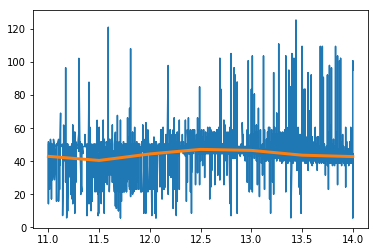

In [40]:
speedRange1 = np.array(
            [k for k in ballastDt if k[3] >= 11 and k[3] <= 14])

speedRange1 = speedRange1[speedRange1[:, 3].argsort()].astype(float)
plt.plot(speedRange1[:,3],speedRange1[:,5])

minSpeed = 11
maxSpeed = 14
raw =  np.array([k for k in ballastDt if   float(k[2])>=0 and float(k[4])>=0 and float(k[3])>minSpeed and
                 float(k[3])<=maxSpeed and float(k[5])>0  ])

i=minSpeed
maxSpeed = maxSpeed
sizesSpeed=[]
speed=[]
avgActualFoc=[]
minActualFoc=[]
maxActualFoc=[]
stdActualFoc=[]
while i <= maxSpeed:
        # workbook._sheets[sheet].insert_rows(k+27)

        speedArray = np.array([k for k in raw if float(k[3]) >= i-0.25 and float(k[3]) <= i + 0.25])

        if speedArray.__len__() > 1:
            sizesSpeed.append(speedArray.__len__())
            speed.append(i)
            avgActualFoc.append(np.mean(speedArray[:, 5]))
            minActualFoc.append(np.min(speedArray[:, 5]))
            maxActualFoc.append(np.max(speedArray[:, 5]))
            stdActualFoc.append(np.std(speedArray[:, 5]))
        i += 0.5

plt.plot(speed,avgActualFoc,lw=3)
plt.show()

In [27]:
lr1 = LinearRegression()
lr1.fit(speedRange1[:, 4].reshape(-1, 1), speedRange1[:, 5].reshape(-1, 1))

lr2 = LinearRegression()
lr2.fit(speedRange2[:, 4].reshape(-1, 1), speedRange2[:, 5].reshape(-1, 1))

lr3 = LinearRegression()
lr3.fit(speedRange3[:, 4].reshape(-1, 1), speedRange3[:, 5].reshape(-1, 1))

LinearRegression()

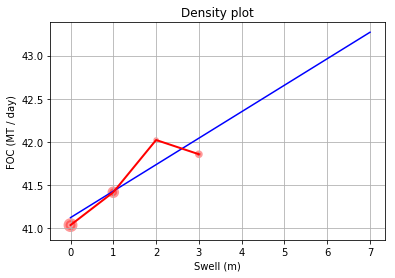

In [51]:
sizesSwell=[]
swell=[]
avgActualFoc=[]
minActualFoc=[]
maxActualFoc=[]
stdActualFoc=[]
maxSwell = 8
minSwell = 0
i=0
rawSwell  = np.array([k for k in speedRange1 if float(k[2]) >= 0 and float(k[2]) <= 3])
while i <= maxSwell:
        
        speedArray = np.array([k for k in rawSwell if float(k[4]) >= i and float(k[4]) <= i + 1])

        if speedArray.__len__() > 0:
            sizesSwell.append(speedArray.__len__())
            swell.append(i)
            avgActualFoc.append(np.mean(speedArray[:, 5]))
            minActualFoc.append(np.min(speedArray[:, 5]))
            maxActualFoc.append(np.max(speedArray[:, 5]))
            stdActualFoc.append(np.std(speedArray[:, 5]))
        i += 1
        
plt.plot(swell, avgActualFoc, label='Mean Foc / Swell',lw=2,zorder=20,color='red')
plt.xlabel('Swell')
plt.ylabel('Mean FOC')



xi = np.array(swell)
yi = np.array(avgActualFoc)
zi = np.array(sizesSwell)

p2 = np.poly1d(np.polyfit(xi, yi, 1))


xp = np.arange(0,8)
#plt.plot([], [], '.', xp, lrSpeedFoc.predict(np.array(xp).reshape(-1,1)))
plt.plot(xp ,p2(xp),c='blue')

plt.scatter(xi, yi, s=zi / 10, c="red", alpha=0.4, linewidth=4)
     
plt.xlabel("Swell (m)")
plt.ylabel("FOC (MT / day)")
plt.grid()
plt.title("Density plot", loc="center")
plt.show()

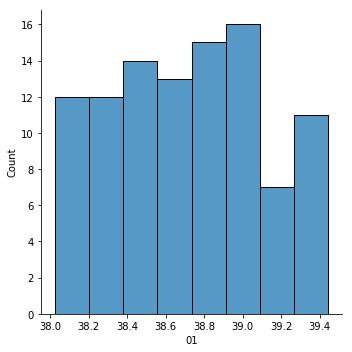

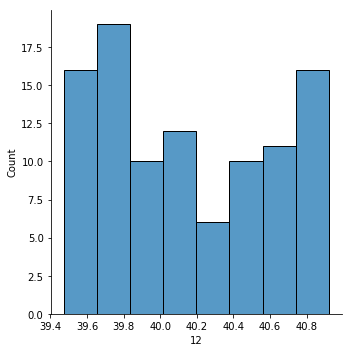

In [81]:
swell01 = np.array([random.uniform(0, 1) for p in range(0, 100)])
swell12 = np.array([random.uniform(1, 2) for p in range(0, 100)])

swell23 = np.array([random.uniform(2, 3) for p in range(0, 100)])
swell34 = np.array([random.uniform(3, 4) for p in range(0, 100)])
swell45 = np.array([random.uniform(4, 5) for p in range(0, 100)])
swell56 = np.array([random.uniform(5, 6) for p in range(0, 100)])
swell67 = np.array([random.uniform(6, 7) for p in range(0, 100)])
swell78 = np.array([random.uniform(7, 8) for p in range(0, 100)])


p2_01 = p2(swell01)
p2_12 = p2(swell12)
p2_23 = p2(swell23)
p2_34 = p2(swell34)
p2_45 = p2(swell45)
p2_56 = p2(swell56)
p2_67 = p2(swell67)
p2_78 = p2(swell78)


df01 = {'01':p2_01}
df12 = {'12':p2_12}

sns.displot(df01,x='01')
sns.displot(df12,x='12')

In [84]:
factorSWH = [0, abs((np.mean(p2_12) - np.mean(p2_01))/ np.mean(p2_01)),
                abs((np.mean(p2_23) - np.mean(p2_12))/ np.mean(p2_12)),
                abs((np.mean(p2_34) - np.mean(p2_23))/ np.mean(p2_23)),
                abs((np.mean(p2_45) - np.mean(p2_34))/ np.mean(p2_34)),
                abs((np.mean(p2_56) - np.mean(p2_45))/ np.mean(p2_45)),
                abs((np.mean(p2_67) - np.mean(p2_56))/ np.mean(p2_56)),
                abs((np.mean(p2_78) - np.mean(p2_67))/ np.mean(p2_67)) ]
dfFactors = pd.DataFrame(factorSWH)
dfFactors

,0
0,0.000000
1,0.037221
2,0.036391
3,0.038010
4,0.031458
5,0.034675
6,0.030580
7,0.029537


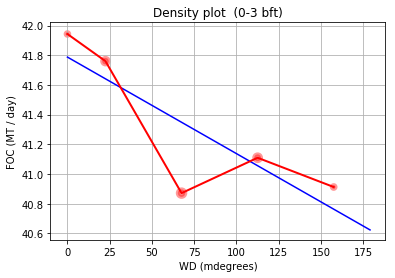

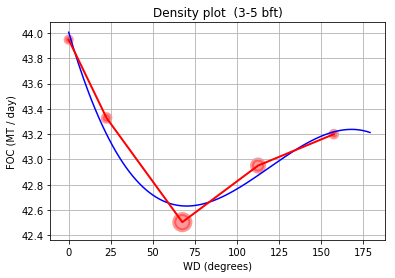

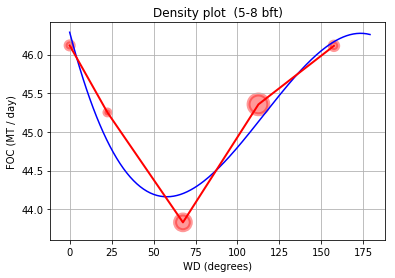

In [49]:
sizesWD=[]
wd=[]
avgActualFoc=[]
minActualFoc=[]
maxActualFoc=[]
stdActualFoc=[]
maxWD = 180
minWD = 0
i=0
listWD=[0,22.5,67.5,112.5,157.5,180]
rawWD  = np.array([k for k in speedRange1 if float(k[2]) >= 0 and float(k[2]) <= 3])
while i <= len(listWD)-1:
        
        speedArray = np.array([k for k in rawWD if float(k[1]) >= listWD[i] and float(k[1]) <= listWD[i + 1]])

        if speedArray.__len__() > 0:
            sizesWD.append(speedArray.__len__())
            wd.append(np.mean(listWD[i:i+1]))
            avgActualFoc.append(np.mean(speedArray[:, 5]))
            minActualFoc.append(np.min(speedArray[:, 5]))
            maxActualFoc.append(np.max(speedArray[:, 5]))
            stdActualFoc.append(np.std(speedArray[:, 5]))
        i += 1
        
plt.plot(wd, avgActualFoc, label='Mean Foc / WD',lw=2,zorder=20,color='red')
plt.xlabel('WD (degrees)')
plt.ylabel('Mean FOC')



xi = np.array(wd)
yi = np.array(avgActualFoc)
zi = np.array(sizesWD)

p2 = np.poly1d(np.polyfit(xi, yi, 1))



xp = np.arange(0,180)
#plt.plot([], [], '.', xp, lrSpeedFoc.predict(np.array(xp).reshape(-1,1)))
plt.plot(xp ,p2(xp),c='blue')

plt.scatter(xi, yi, s=zi / 10, c="red", alpha=0.4, linewidth=4)
plt.xlabel("WD (mdegrees)")
plt.ylabel("FOC (MT / day)")
plt.grid()
plt.title("Density plot  (0-3 bft)", loc="center")
plt.show()

########3-5

sizesWD=[]
wd=[]
avgActualFoc=[]
minActualFoc=[]
maxActualFoc=[]
stdActualFoc=[]
maxWD = 180
minWD = 0
i=0
listWD=[0,22.5,67.5,112.5,157.5,180]
rawWD  = np.array([k for k in speedRange1 if float(k[2]) >3 and float(k[2]) <= 5])
while i <= len(listWD)-1:
        
        speedArray = np.array([k for k in rawWD if float(k[1]) >= listWD[i] and float(k[1]) <= listWD[i + 1]])

        if speedArray.__len__() > 0:
            sizesWD.append(speedArray.__len__())
            wd.append(np.mean(listWD[i:i+1]))
            avgActualFoc.append(np.mean(speedArray[:, 5]))
            minActualFoc.append(np.min(speedArray[:, 5]))
            maxActualFoc.append(np.max(speedArray[:, 5]))
            stdActualFoc.append(np.std(speedArray[:, 5]))
        i += 1
        
plt.plot(wd, avgActualFoc, label='Mean Foc / WD',lw=2,zorder=20,color='red')
plt.xlabel('WD (degrees)')
plt.ylabel('Mean FOC')



xi = np.array(wd)
yi = np.array(avgActualFoc)
zi = np.array(sizesWD)

p2 = np.poly1d(np.polyfit(xi, yi, 3))



xp = np.arange(0,180)
#plt.plot([], [], '.', xp, lrSpeedFoc.predict(np.array(xp).reshape(-1,1)))
plt.plot(xp ,p2(xp),c='blue')

plt.scatter(xi, yi, s=zi / 10, c="red", alpha=0.4, linewidth=4)
plt.xlabel("WD (degrees)")
plt.ylabel("FOC (MT / day)")
plt.grid()
plt.title("Density plot  (3-5 bft)", loc="center")
plt.show()

########## 5- 8 

sizesWD=[]
wd=[]
avgActualFoc=[]
minActualFoc=[]
maxActualFoc=[]
stdActualFoc=[]
maxWD = 180
minWD = 0
i=0
listWD=[0,22.5,67.5,112.5,157.5,180]
rawWD  = np.array([k for k in speedRange1 if float(k[2]) >5 and float(k[2]) <= 9])
while i <= len(listWD)-1:
        
        speedArray = np.array([k for k in rawWD if float(k[1]) >= listWD[i] and float(k[1]) <= listWD[i + 1]])

        if speedArray.__len__() > 0:
            sizesWD.append(speedArray.__len__())
            wd.append(np.mean(listWD[i:i+1]))
            avgActualFoc.append(np.mean(speedArray[:, 5]))
            minActualFoc.append(np.min(speedArray[:, 5]))
            maxActualFoc.append(np.max(speedArray[:, 5]))
            stdActualFoc.append(np.std(speedArray[:, 5]))
        i += 1
        
plt.plot(wd, avgActualFoc, label='Mean Foc / WD',lw=2,zorder=20,color='red')
plt.xlabel('WD (degrees)')
plt.ylabel('Mean FOC')



xi = np.array(wd)
yi = np.array(avgActualFoc)
zi = np.array(sizesWD)

p2 = np.poly1d(np.polyfit(xi, yi, 3))



xp = np.arange(0,180)
#plt.plot([], [], '.', xp, lrSpeedFoc.predict(np.array(xp).reshape(-1,1)))
plt.plot(xp ,p2(xp),c='blue')

plt.scatter(xi, yi, s=zi / 10, c="red", alpha=0.4, linewidth=4)
plt.xlabel("WD (degrees)")
plt.ylabel("FOC (MT / day)")
plt.grid()
plt.title("Density plot  (5-8 bft)", loc="center")
plt.show()

### WIND SPEED FACTORS

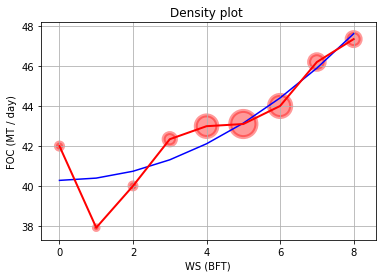

In [56]:
sizesWS=[]
ws=[]
avgActualFoc=[]
minActualFoc=[]
maxActualFoc=[]
stdActualFoc=[]
maxWS = 8
minWS = 0
i=0

rawWD  = np.array([k for k in speedRange1 if float(k[4]) >= 0 and float(k[4]) <= 1])
while i <= 8:
        
        speedArray = np.array([k for k in rawWD if float(k[2]) >= i and float(k[2]) <= i + 1])

        if speedArray.__len__() > 0:
            sizesWS.append(speedArray.__len__())
            ws.append(i)
            avgActualFoc.append(np.mean(speedArray[:, 5]))
            minActualFoc.append(np.min(speedArray[:, 5]))
            maxActualFoc.append(np.max(speedArray[:, 5]))
            stdActualFoc.append(np.std(speedArray[:, 5]))
        i += 1
        
plt.plot(ws, avgActualFoc, label='Mean Foc / WS',lw=2,zorder=20,color='red')
plt.xlabel('WD (degrees)')
plt.ylabel('Mean FOC')



xi = np.array(ws)
yi = np.array(avgActualFoc)
zi = np.array(sizesWS)

p2 = np.poly1d(np.polyfit(xi, yi, 2))



xp = np.arange(0,9)
#plt.plot([], [], '.', xp, lrSpeedFoc.predict(np.array(xp).reshape(-1,1)))
plt.plot(xp ,p2(xp),c='blue')

plt.scatter(xi, yi, s=zi / 10, c="red", alpha=0.4, linewidth=4)
plt.xlabel("WS (BFT)")
plt.ylabel("FOC (MT / day)")
plt.grid()
plt.title("Density plot ", loc="center")
plt.show()



### New statistical algorithm validation

In [65]:
router = APIRouter()
@router.get("/")
async def get_ModelComparison(interpolation):
    response = requests.get("https://localhost:5001/CompareConsumptionModels/?interpolation="+interpolation,verify=False)
    return response.text

modelComp = await get_ModelComparison("true")
json_dict = json.load(io.StringIO(modelComp))
df = pd.concat([pd.DataFrame(json_dict)])
df


/home/dimitris/.local/lib/python3.6/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,speed,size,neuralDT_Acc,statsDT_Acc,actual_Avg,neuralDT_Avg,stats_Avg,neuralDT_RMSE,stats_RMSE
0,10.0,10,0.184669,-0.015603,38.005000,45.023345,37.412000,0.007384,0.008985
1,10.5,40,0.311690,0.123929,32.337000,42.416105,36.344500,0.008193,0.008784
2,11.0,31,0.154225,-0.128037,43.029677,49.665921,37.520300,0.006935,0.007611
3,11.5,54,0.141552,-0.162992,43.640556,49.817978,36.527495,0.007994,0.009016
4,12.0,72,0.194089,-0.067210,44.042500,52.590665,41.082413,0.008220,0.006270
5,12.5,156,0.177402,0.103329,47.743205,56.212940,52.676472,0.008878,0.006321
6,13.0,211,0.149550,0.048829,49.735640,57.173599,52.164169,0.010802,0.006064
7,13.5,571,0.135266,0.055081,45.571559,51.735839,48.081697,0.007511,0.005174
8,14.0,1287,0.068238,0.060791,42.810249,45.731534,45.412737,0.004341,0.003254
9,14.5,326,0.003661,-0.063092,48.619877,48.797864,45.552349,0.008226,0.009884


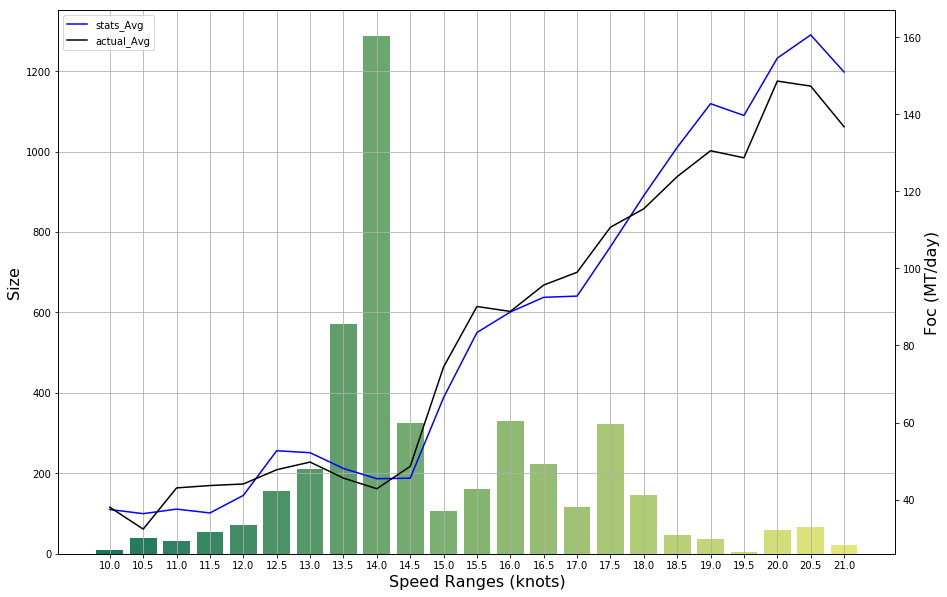

In [66]:
df['speed']= [str(k) for k in df['speed'].values]


def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


#print(df.dtypes)

#sns.set(font_scale=1) 
fig, ax1 = plt.subplots(figsize=(15,10))
color = 'tab:green'
#bar plot creation
y_pos = [0,1,5,8,9,11,12,13,14]
bars = df['size']
plt.xticks(y_pos, bars)

ax1 = sns.barplot(x='speed', y='size', data = df, palette='summer',ci="sd")
ax1.set_xlabel('Speed Ranges (knots)', fontsize=16)
ax1.set_ylabel('Size', fontsize=16)
#change_width(ax1, 1.5)
ax1.tick_params(axis='x')
ax1.set_xticks(np.arange(9, 21.5, step=15.2))
ax1.grid()
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
#ax2.set_ylabel('', fontsize=16)

#ax2 = sns.lineplot(x='speed', y='neuralDT_Avg', data = df, sort=False, color='red',label='neuralDT_Avg')
ax2 = sns.lineplot(x='speed', y='stats_Avg', data = df, sort=False, color='blue',label='stats_Avg')
ax2 = sns.lineplot(x='speed', y='actual_Avg', data = df, sort=False, color='black',label='actual_Avg')
ax2.set_ylabel('Foc (MT/day)', fontsize=16)
ax2.grid()


plt.legend()
plt.grid()
plt.show()